In [1]:
# import packages that will be used for plotting and analyzing the data

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
%matplotlib inline

from sklearn.metrics import mean_squared_log_error

from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer, RobustScaler


In [2]:
df = pd.read_csv('Data/train_imputed.csv')

In [3]:
X = df.drop('SalePrice', axis=1)
y = df.SalePrice

In [4]:
X.head()

,MSSubClass,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,3,0,7,5,2003,2003,196.0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,3,0,6,8,1976,1976,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,2,0,7,5,2001,2002,162.0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,2,0,7,5,1915,1970,0.0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,2,0,8,5,2000,2000,350.0,...,0,0,0,1,0,0,0,0,1,0


In [5]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Linear Regression with PCA

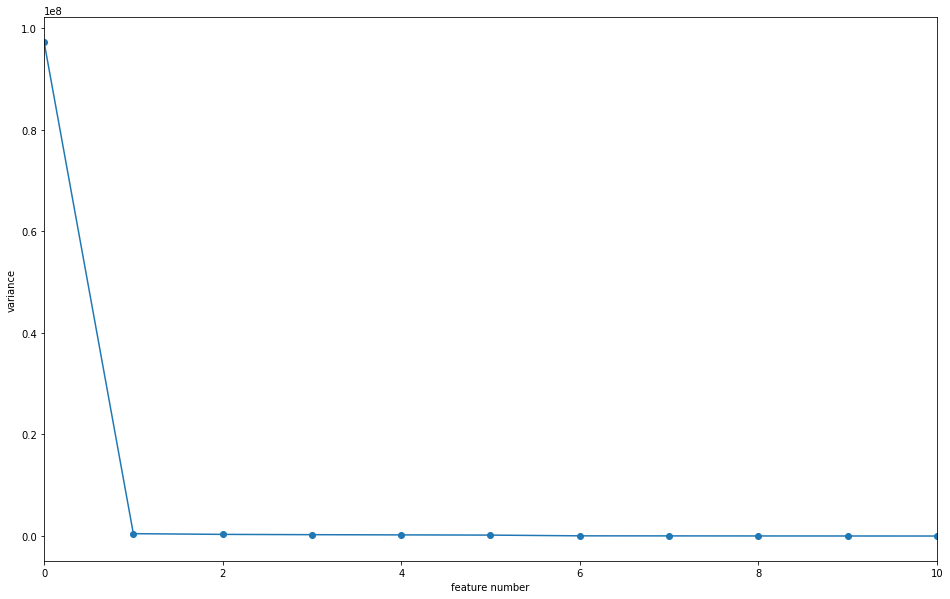

In [6]:
pca = PCA()
pca.fit(X)
features = range(pca.n_components_)
plt.figure(figsize=(16, 10))
plt.plot(features, pca.explained_variance_, '-o')

plt.xlabel('feature number')
plt.ylabel('variance')
plt.xlim(0, 10)
plt.show()

In [7]:
model=PCA(n_components=1)
model.fit(X)
df_components = pd.DataFrame(model.transform(X))
df_components.columns = ['component1']

In [8]:
df_PCA = df_components.join(y, how='left')

X_train, X_test, y_train, y_test = train_test_split(df_components, y, test_size=0.3, random_state=10)


In [9]:
reg_PCA = LinearRegression()
reg_PCA.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
reg_PCA.score(X_train, y_train)


0.071536663200562733

In [12]:
param_grid = {'fit_intercept':[True, False], 'normalize':[True, False]}

In [14]:
reg_PCA_cv = GridSearchCV(reg_PCA, param_grid, cv=5)
reg_PCA_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'fit_intercept': [True, False], 'normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
print("Tuned Regression Parameter: {}".format(reg_PCA_cv.best_params_))
print("Tuned Regression Accuracy: {}".format(reg_PCA_cv.best_score_))

Tuned Regression Parameter: {'fit_intercept': True, 'normalize': False}
Tuned Regression Accuracy: 0.06309087925394023


In [16]:
y_pred_PCA = reg_PCA.predict(X_test)

rmsle(y_test, y_pred_PCA)

0.39415452638645798

# Linear Regression (out of box)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


In [21]:
reg_oob = LinearRegression()
reg_oob.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
reg_oob.score(X_train, y_train)

0.93195435558885431

In [24]:
y_pred_reg_oob = reg_oob.predict(X_test)

mean_squared_log_error(y_test, y_pred_reg_oob)

0.037353596115682994

# Linear Regression with VIF

In [25]:
# from https://www.kaggle.com/ffisegydd/sklearn-multicollinearity-class/code

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [26]:
transformer = ReduceVIF()
X = transformer.fit_transform(X, y)

ReduceVIF fit
ReduceVIF transform


C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dropping BsmtFinSF1 with vif=inf
Dropping 1stFlrSF with vif=inf
Dropping MSZoning_C (all) with vif=inf
Dropping MSZoning_FV with vif=inf
Dropping MSZoning_RH with vif=inf
Dropping MSZoning_RL with vif=inf
Dropping MSZoning_RM with vif=inf
Dropping Street_Grvl with vif=inf
Dropping Alley_Grvl with vif=inf
Dropping LandContour_Bnk with vif=inf
Dropping Utilities_AllPub with vif=inf
Dropping LotConfig_Corner with vif=inf
Dropping Neighborhood_Blmngtn with vif=inf
Dropping Condition1_Artery with vif=inf
Dropping Condition2_Artery with vif=inf
Dropping BldgType_1Fam with vif=inf
Dropping HouseStyle_1.5Fin with vif=inf
Dropping RoofStyle_Flat with vif=inf
Dropping RoofMatl_CompShg with vif=inf
Dropping Exterior1st_AsbShng with vif=inf
Dropping Exterior1st_CBlock with vif=inf
Dropping Exterior2nd_AsbShng with vif=inf
Dropping MasVnrType_BrkCmn with vif=inf
Dropping Foundation_BrkTil with vif=inf
Dropping Heating_Floor with vif=inf
Dropping Electrical_C (all) with vif=inf
Dropping GarageType_2

C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\statsmodels\regression\linear_model.py:1388: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Dropping YrSold with vif=107936.87267922967
Dropping YearBuilt with vif=41350.357198712394
Dropping GarageYrBlt with vif=25541.63859314166
Dropping YearRemodAdd with vif=16586.198363510255
Dropping MiscFeature_None with vif=4690.908755522898
Dropping Heating_GasA with vif=1214.9290243614744
Dropping Condition2_Norm with vif=750.150798846286
Dropping RoofStyle_Gable with vif=507.77679573190903
Dropping Street_Pave with vif=340.84799761950774
Dropping GarageCond with vif=324.50705308189475
Dropping GrLivArea with vif=187.85206696499716
Dropping GarageQual with vif=186.04066952304632
Dropping Electrical_RL with vif=172.54226871823627
Dropping Exterior1st_VinylSd with vif=162.69600100254928
Dropping GarageType_Attchd with vif=143.12239096356848
Dropping ExterQual with vif=134.34911880574555
Dropping Functional with vif=129.22093790519662
Dropping ExterCond with vif=109.09137123159228
Dropping OverallQual with vif=96.802074631713
Dropping BsmtCond with vif=95.89777542084066
Dropping TotRmsA

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Columns: 138 entries, LotArea to SaleCondition_Partial
dtypes: float64(138)
memory usage: 1.5 MB


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


In [29]:
reg_VIF = LinearRegression()
reg_VIF.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [30]:
reg_VIF.score(X_train, y_train)

0.81944211620960794

In [31]:
y_pred_reg_VIF = reg_VIF.predict(X_test)

rmsle(y_test, y_pred_reg_VIF)

0.22862868456468408

In [32]:
reg_cv = GridSearchCV(reg_VIF, param_grid, cv=5)
reg_cv.fit(X_train,y_train)

print("Tuned Logistic Regression Parameter: {}".format(reg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(reg_cv.best_score_))

Tuned Logistic Regression Parameter: {'fit_intercept': True, 'normalize': False}
Tuned Logistic Regression Accuracy: 0.7020897921742186


In [34]:
y_pred_reg_VIF = reg_VIF.predict(X_test)

rmsle(y_test, y_pred_reg_VIF)

0.22862868456468408

# Lasso Regression

In [35]:
X_scaled = pd.DataFrame(RobustScaler().fit_transform(X))
X_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,-0.252743,0.0,1.196947,0.0,-0.559829,0.0,1.0,0.0,1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.030822,0.0,0.000000,0.0,-0.330769,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.437677,0.0,0.989313,0.0,-0.074359,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.018493,0.0,0.000000,0.0,0.106838,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.179879,0.0,2.137405,0.0,0.021368,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=10)


In [37]:
reg_lasso = Lasso()
reg_lasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [38]:
y_pred_reg_lasso = reg_lasso.predict(X_test)

rmsle(y_test, y_pred_reg_lasso)

0.22766692250875895

# Random Forest

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [40]:
reg_rf = RandomForestClassifier()
reg_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [41]:
y_pred_reg_rf = reg_rf.predict(X_test)

rmsle(y_test, y_pred_reg_rf)

0.38207682840698476

In [42]:
# Specify the hyperparameters to be tested with RandomizedSearchCV

# Number of trees in random forest
n_estimators = [120, 300, 500, 800, 1200]

# Number of features to consider at every split
max_features = ['Log2', 'sqrt', None]

# Maximum number of levels in tree
max_depth = [5, 8, 15, 25, 30, None]

# Minimum number of samples required to split a node
min_samples_split = [1, 2, 5, 10, 15, 100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_cv = GridSearchCV(rf, param_grid, cv=5)
rf_cv.fit(X, y)

In [43]:
# Use the random grid to search for best hyperparameters

# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=10, n_jobs = -1)

# Fit the random search model
rf_random.fit(X, y)

NameError: name 'rf' is not defined

# XGBoost

In [45]:
reg_xgb = xgb.XGBRegressor()
reg_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [47]:
reg_xgb.score(X_train, y_train)

0.8965915201780108

In [48]:
y_pred_xgb = reg_xgb.predict(X_test)

rmsle(y_test, y_pred_xgb)

0.21115986719320282

In [49]:
# Test Parameters
eta = [0.01, 0.015, 0.025, 0.05, 0.1]
gamma = [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
max_depth = [3, 5, 7, 9, 12, 15, 17, 25]
min_child_weight = [1, 3, 5, 7]
subsample = [0.6, 0.7, 0.8, 0.9, 1.0]
colsample_bytree = [0.6, 0.7, 0.8, 0.9, 1.0]
lamb = [0.01, 0.1, 1.0]
alpha = [0, 0.1, 0.5, 1.0]

# Create the random grid
random_grid = {'eta': eta, 
               'gamma': gamma,
               'max_depth': max_depth, 
               'min_child_weight': min_child_weight, 
               'subsample': subsample, 
               'colsample_bytree': colsample_bytree, 
               'lambda': lamb, 
               'alpha': alpha}